# Customer Churn Prediction with a Neural Network (Beginner-Friendly Guide)

This notebook walks through a complete workflow for predicting customer churn using a neural network.  
The goal is to show **best practices** step-by-step, while keeping the implementation clear and beginner-friendly.

---

## 🏁 1. Importing Libraries

We begin by importing the core data science libraries:

- **NumPy & Pandas** → Data manipulation and analysis  
- **Matplotlib & Seaborn** → Data visualization and exploratory analysis  

We will use these tools to explore the dataset before building the predictive model.


In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## 📂 2. Loading the Dataset

We load the churn dataset from CSV.  
Using `.head()` gives us a preview of the first few rows, helping us understand the structure, column names, and the type of features we have.

---

In [2]:
dataset = pd.read_csv("Churn_Modelling.csv")

In [3]:
dataset.head()

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

## 🎯 3. Separating Features and Target

- `X` contains the **input features** used to make predictions.
- `y` is the **target variable**, indicating whether the customer churned (`Exited = 1`) or stayed (`Exited = 0`).

Identifier columns that do not provide predictive value are excluded.


In [4]:
X = dataset.iloc[:, 3:-1]
y = dataset['Exited']

## 📊 4. Checking Class Distribution

We visualize the distribution of churn labels.  
Churn datasets are typically **imbalanced**, meaning many more customers stay than leave.  
Recognizing this early is important because imbalance directly affects model training.

---

<Axes: xlabel='Exited', ylabel='count'>

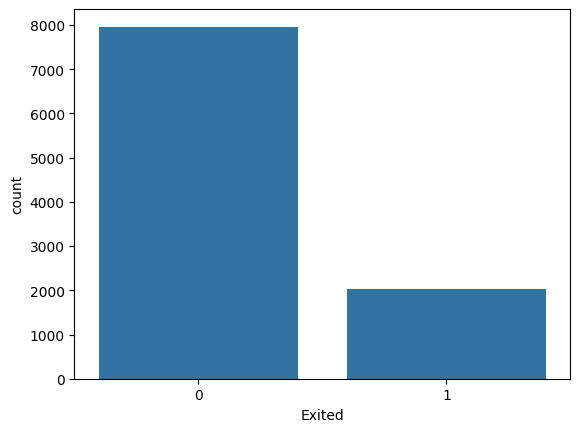

In [5]:
sns.countplot(x=y)

## 🔍 5. Visualizing Feature Relationships

We examine how key categorical and discrete numeric features relate to churn.  
This helps us identify meaningful patterns, for example, churn may vary by geography, product usage, or customer activity level.

Understanding the **shape of the data** prevents blindly training models.

---

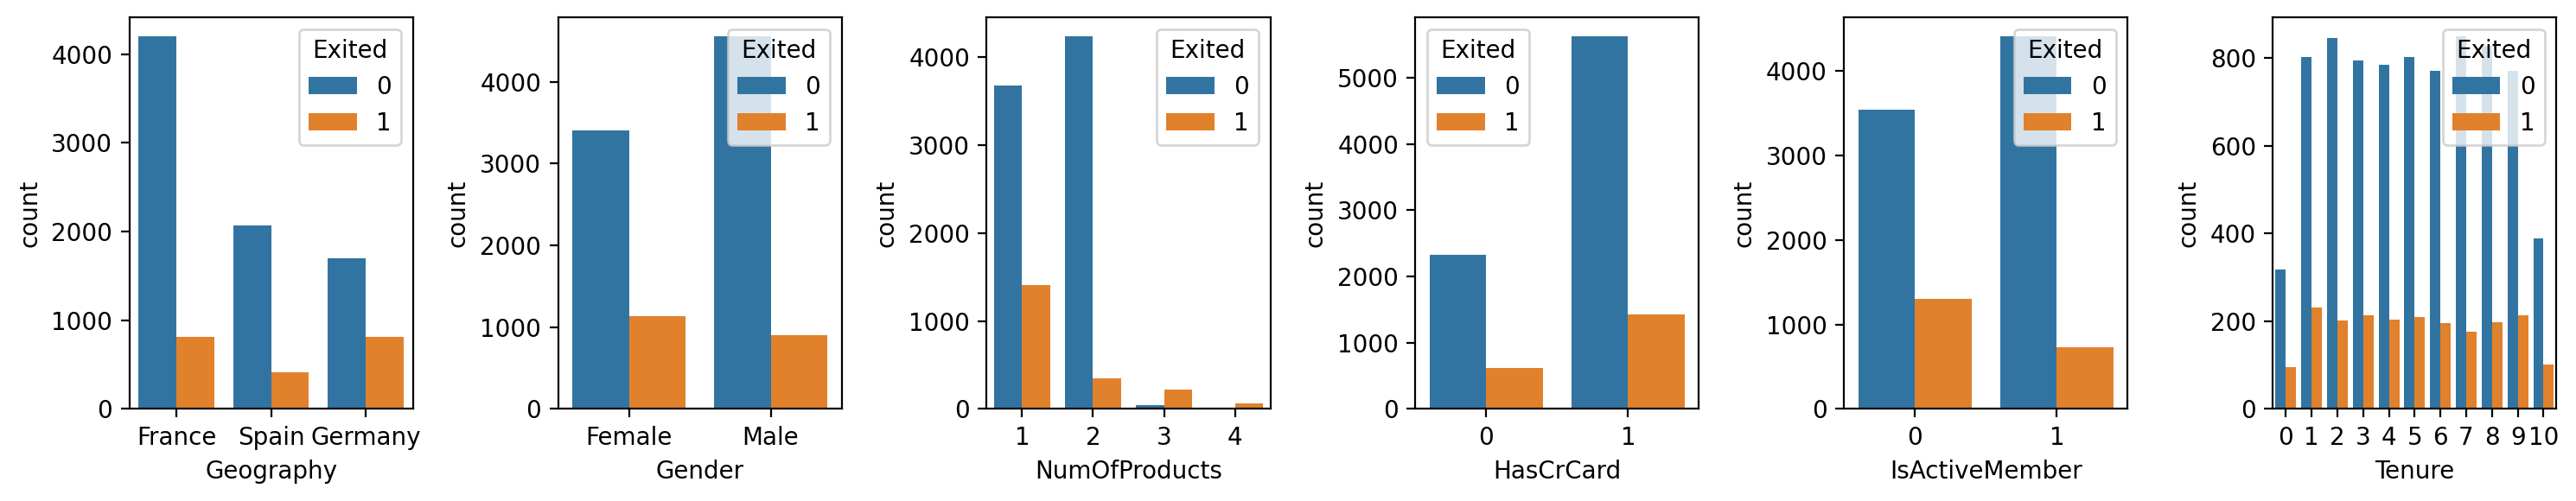

In [6]:
plt.rcParams['figure.figsize'] = (15,3)
plt.rcParams['figure.dpi'] = 200

fig,ax = plt.subplots(1,6)
sns.countplot(x = "Geography", data = X, ax = ax[0], hue = y)
sns.countplot(x = "Gender", data = X, ax = ax[1], hue = y)
sns.countplot(x = "NumOfProducts", data = X, ax = ax[2], hue = y)
sns.countplot(x = "HasCrCard", data = X, ax = ax[3], hue = y)
sns.countplot(x = "IsActiveMember", data = X, ax = ax[4], hue = y)
sns.countplot(x = "Tenure", data = X, ax = ax[5], hue = y)

plt.tight_layout()

## 🔢 6. Inspecting Feature Columns

Listing the feature names confirms which variables we are working with before preprocessing.

---

In [7]:
X.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'],
      dtype='object')

## 👁️ 7. Pairwise Feature Relations by Gender

This pairplot visualizes relationships between continuous features, colored by gender.  
The goal is exploratory understanding, not modeling, to check natural group differences.

---

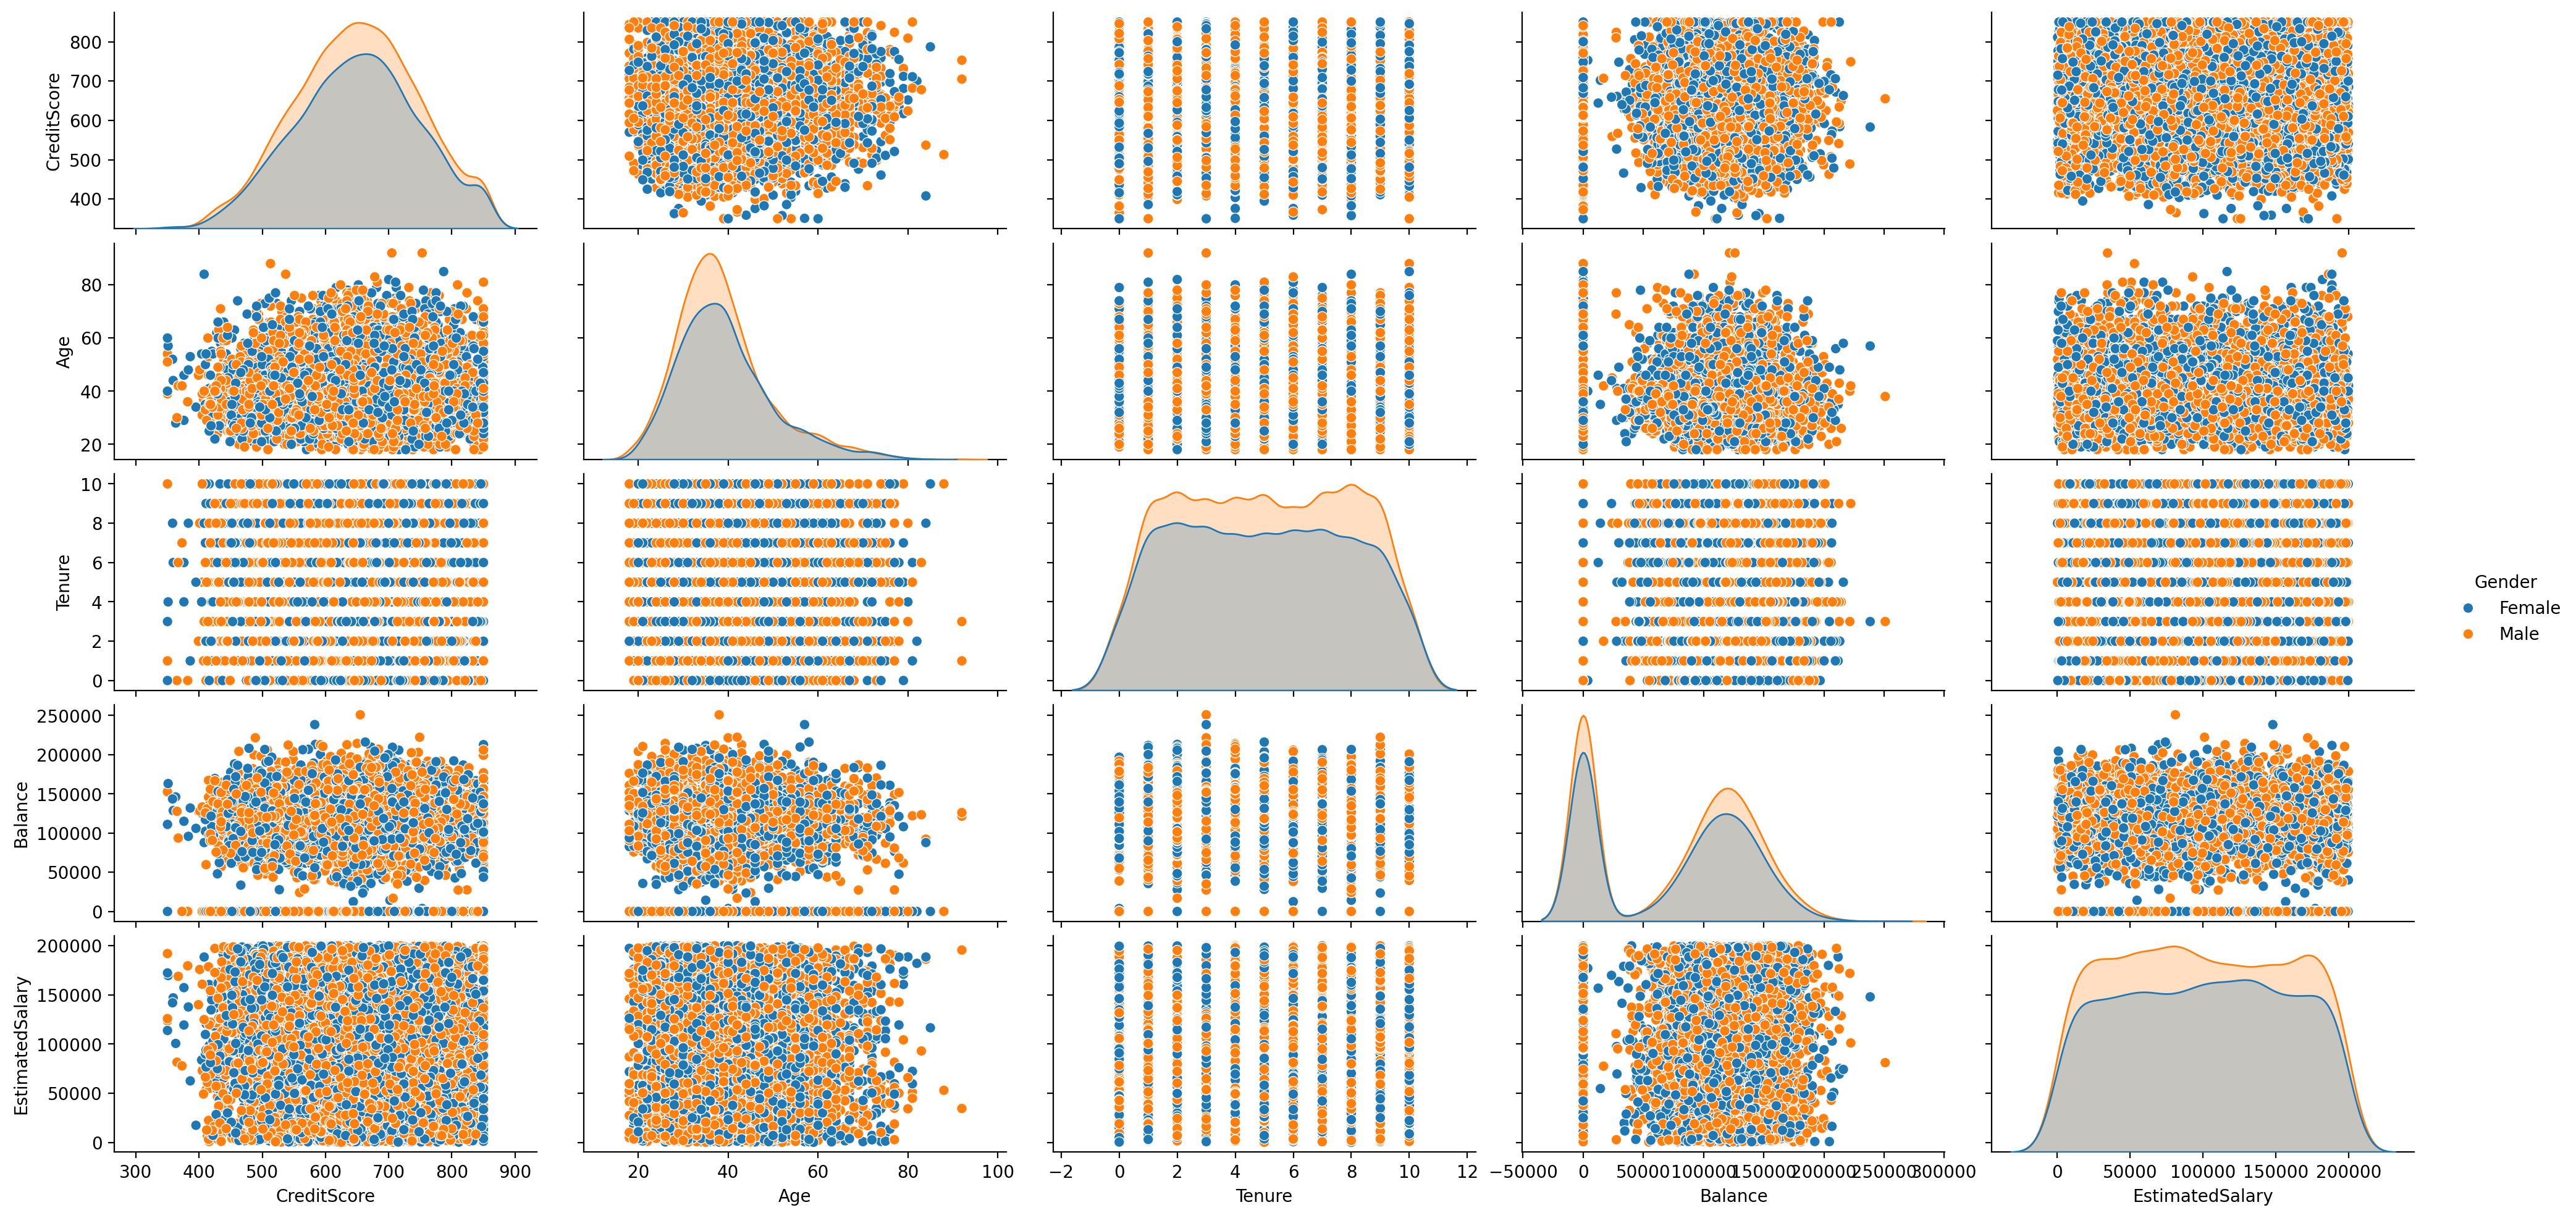

In [8]:
sns.pairplot(dataset, vars = ['CreditScore', 'Age', 'Tenure', 'Balance','EstimatedSalary'],
             height = 2, aspect = 2, hue = 'Gender')

## 👁️ 8. Pairwise Feature Relations by Churn

We repeat the pairplot, colored by churn outcome.  
Here we look for separation between churned and retained customers in numeric space, helpful for intuition about model difficulty.

---

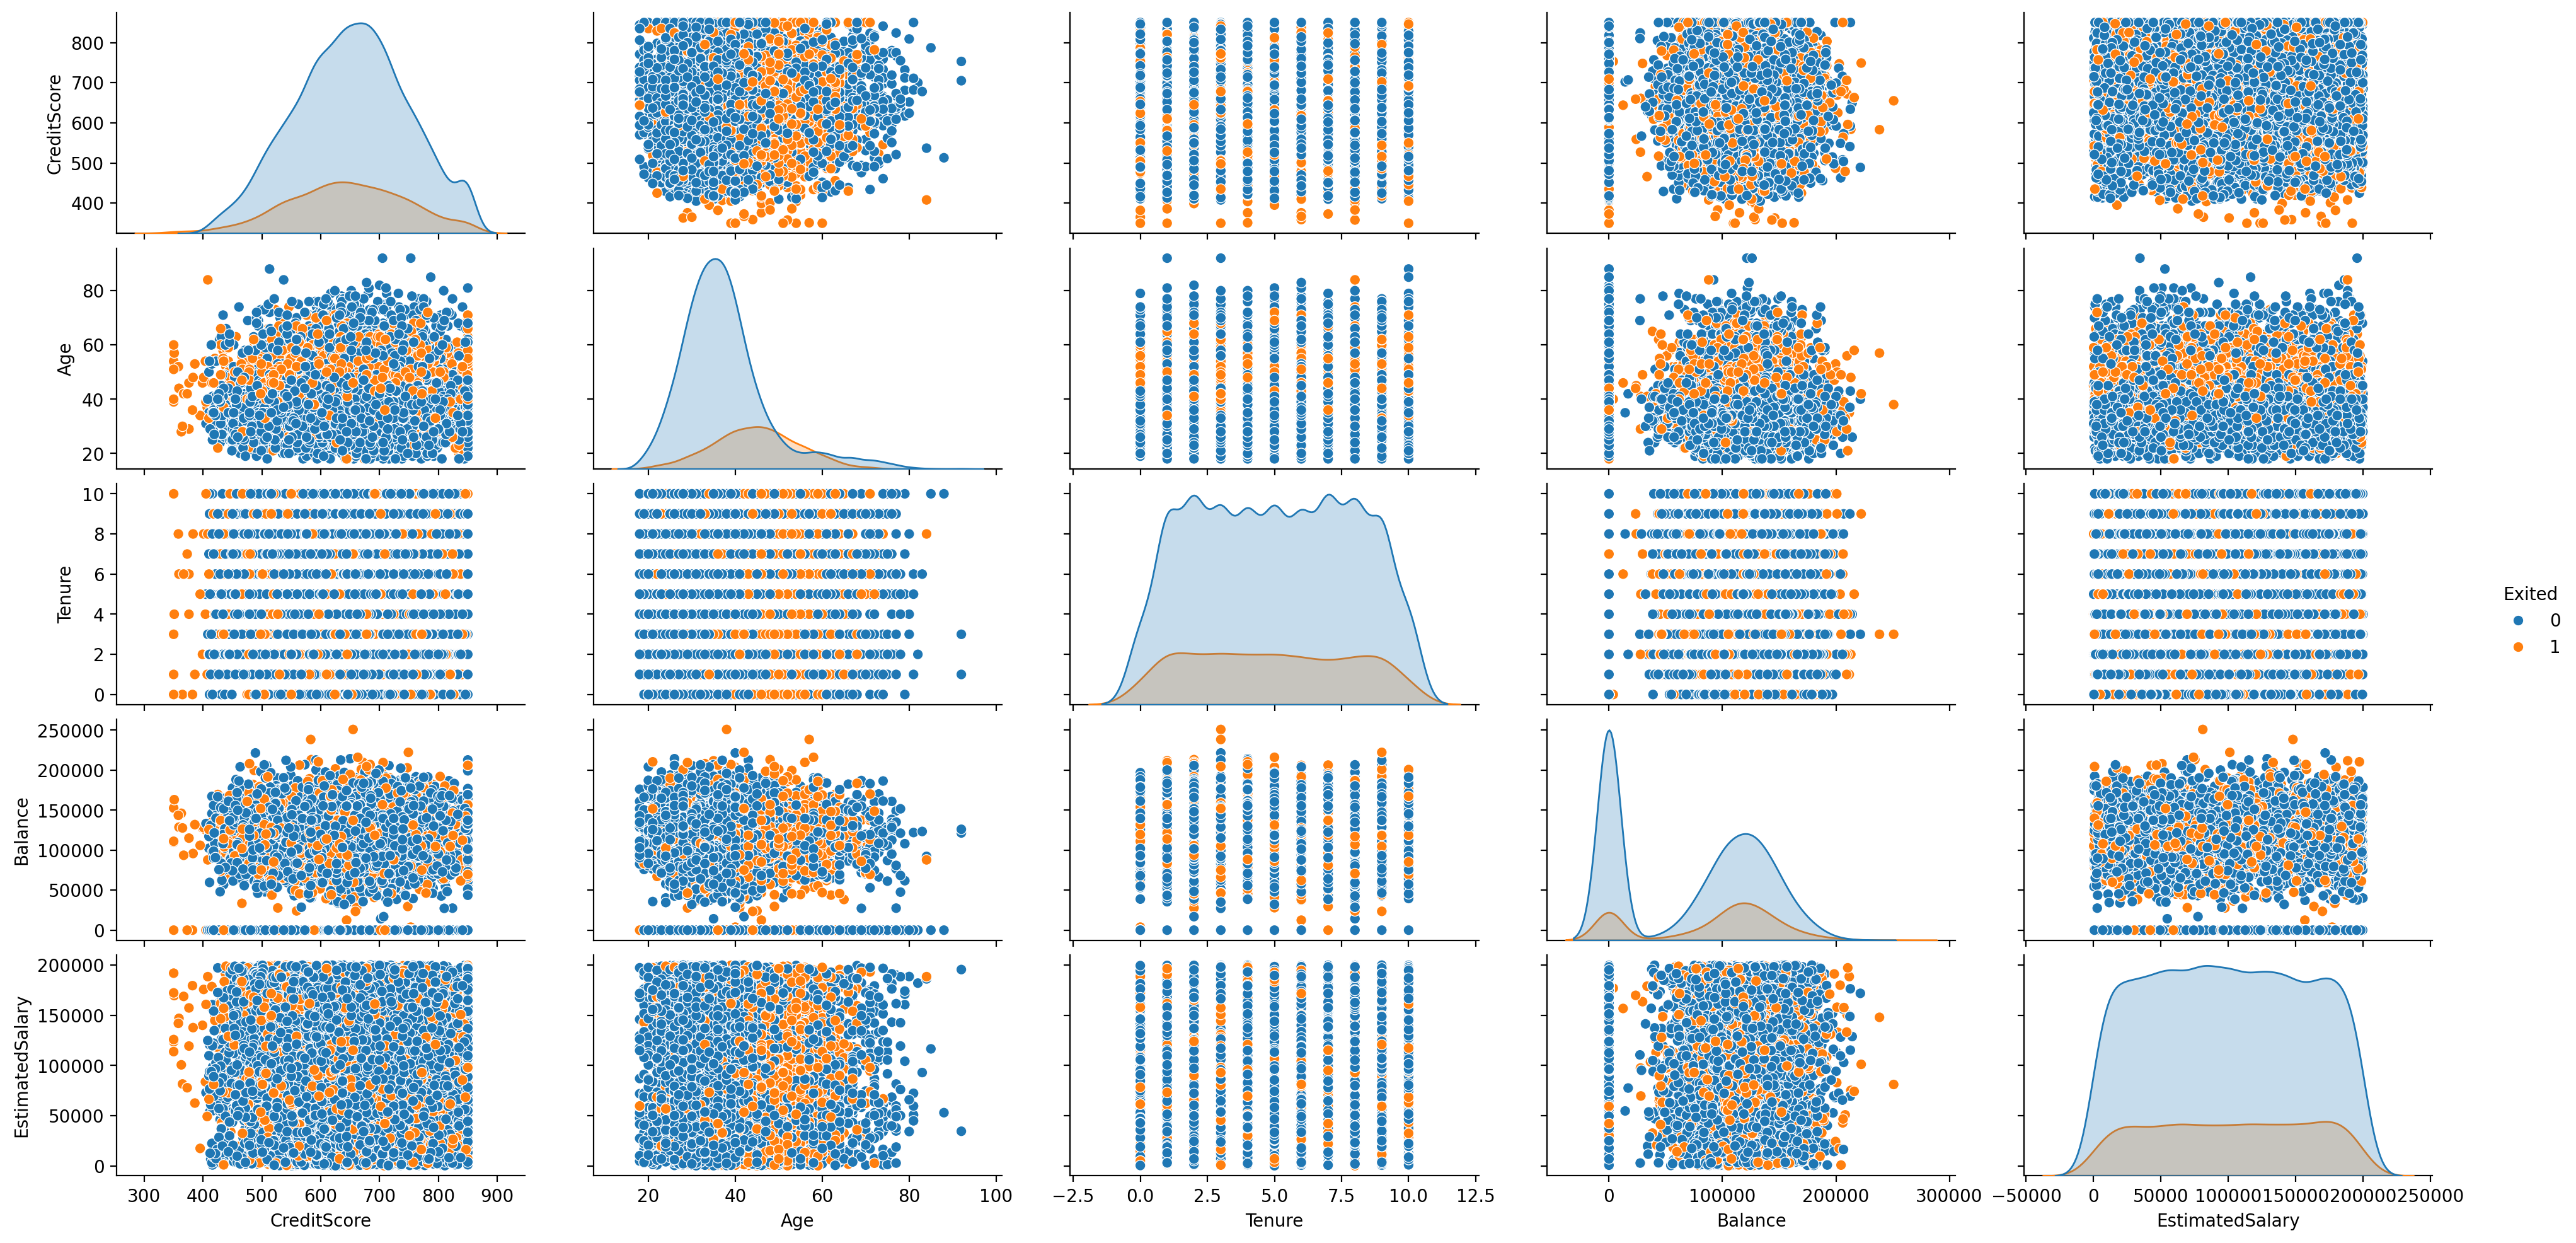

In [9]:
sns.pairplot(dataset, vars = ['CreditScore', 'Age', 'Tenure', 'Balance','EstimatedSalary'],
             height = 2, aspect = 2, hue = 'Exited')

## 🧱 9. Importing Preprocessing Tools

We import utilities needed for:
- Splitting data into train and test sets
- Feature normalization

These are standard steps in any machine learning pipeline.

---

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## 🎭 10. One-Hot Encoding Categorical Variables

Categorical variables are converted into numeric form using `get_dummies()`.  
`drop_first=True` avoids redundant dummy columns (the “dummy variable trap”).

This step ensures our model receives purely numeric inputs.

---

In [11]:
X_onehot = pd.get_dummies(X, drop_first=True).astype(int)

## ✂️ 11. Train–Test Split

We divide the data into:
- Training set → used to fit the model
- Test set → used to evaluate generalization

`stratify=y` ensures that the churn ratio remains consistent across both sets, this is a **good practice**.

---

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_onehot, y, test_size = 0.2,
                                                    random_state = 42, stratify = y)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,  # Split from X_train, NOT X_onehot
    test_size=0.1,     # 10% of training for validation
    random_state=42, 
    stratify=y_train   # Stratify on y_train
)

## ⚖️ 12. Feature Scaling

We standardize numerical feature values so they have mean = 0 and variance = 1.  
This helps the neural network train more efficiently and prevents features with large numeric ranges from dominating.

---

In [13]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit and transform
X_val = scaler.transform(X_val)          # Only transform
X_test = scaler.transform(X_test)        # Only transform

## 🤖 13. Importing TensorFlow Model Components

We import modules required to build a neural network using Keras:
- Dense layers
- Dropout (regularization)
- BatchNormalization (training stability)

---

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Flatten, Dense, InputLayer, Dropout

from tensorflow.keras.optimizers import Adam


## 📐 14. Defining Input Shape

We capture the number of features in the final processed dataset so we can define the model architecture properly.

---

## 📉 15. Checking Class Balance

We examine how many customers churned vs. didn’t.  
Confirming an imbalance motivates use of **class weighting** later, preventing the model from learning to always predict “no churn.”

---

In [15]:
y.value_counts().to_dict()

{0: 7963, 1: 2037}

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

## ⚖️ 16. Computing Class Weights

We compute weights so the algorithm penalizes misclassifying churn cases more strongly.  
This helps improve Recall and F1-score for the minority class.

---

In [17]:
class_weights = compute_class_weight(
    'balanced', 
    classes=np.unique(y_train), 
    y=y_train
)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print(f"Class weights: {class_weight_dict}")
print(f"Class distribution: {y_train.value_counts().to_dict()}")

Class weights: {0: 0.6279434850863422, 1: 2.4539877300613497}
Class distribution: {0: 5733, 1: 1467}


In [18]:
class_weights 

array([0.62794349, 2.45398773])

## 🧠 17. Building the Neural Network

The model consists of:
- Dense layers to learn feature patterns
- Batch normalization to stabilize learning
- Dropout layers to reduce overfitting
- Sigmoid output activation for binary classification

The architecture is intentionally simple but effective.

---

In [21]:
model = Sequential([
    Dense(64, activation=None, input_shape=(X_train.shape[1],)),  # No activation here
    BatchNormalization(),
    Activation('relu'),  # Activation after BN
    Dropout(0.3),
    
    Dense(32, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.3),
    
    Dense(16, activation=None),
    Activation('relu'),  # Can skip BN on smaller layers
    Dropout(0.2),
    
    Dense(1, activation='sigmoid')
])


## 🪢 18. Setting Up Callbacks

We use:
- **EarlyStopping** → stops training before overfitting
- **ReduceLROnPlateau** → reduces learning rate when improvement slows

These techniques improve training stability and final model performance.

In [22]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001,
    verbose=1
)

## 🏗️ 19. Model Summary

We display the model structure to review layer shapes and parameter counts.

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 64)                768       
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_2 (Batc  (None, 32)               128       
 hNormalization)                                        

## ⚙️ 20. Compiling the Model

We train using:
- **Adam** optimizer
- **Binary Crossentropy** as loss function (correct for binary classification)


In [24]:
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

## 🚀 21. Training the Model

We train using:
- Mini-batches of size 32
- Validation split (10%)
- Class weights to handle imbalance
- Callbacks for stability and regularization

---

In [25]:
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_val, y_val),  # Changed from validation_split
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/50
225/225 [==============================] - 3s 5ms/step - loss: 0.7206 - accuracy: 0.5843 - val_loss: 0.6691 - val_accuracy: 0.6012 - lr: 5.0000e-04
Epoch 2/50
225/225 [==============================] - 1s 4ms/step - loss: 0.6570 - accuracy: 0.6192 - val_loss: 0.6365 - val_accuracy: 0.6488 - lr: 5.0000e-04
Epoch 3/50
225/225 [==============================] - 1s 4ms/step - loss: 0.6280 - accuracy: 0.6418 - val_loss: 0.6000 - val_accuracy: 0.6900 - lr: 5.0000e-04
Epoch 4/50
225/225 [==============================] - 1s 4ms/step - loss: 0.6171 - accuracy: 0.6676 - val_loss: 0.5818 - val_accuracy: 0.7038 - lr: 5.0000e-04
Epoch 5/50
225/225 [==============================] - 1s 4ms/step - loss: 0.6051 - accuracy: 0.6681 - val_loss: 0.5556 - val_accuracy: 0.7188 - lr: 5.0000e-04
Epoch 6/50
225/225 [==============================] - 1s 4ms/step - loss: 0.5911 - accuracy: 0.6862 - val_loss: 0.5413 - val_accuracy: 0.7287 - lr: 5.0000e-04
Epoch 7/50
225/225 [==========================

## 🧪 22. Evaluating Model Performance

We measure test accuracy and loss on unseen data to estimate generalization quality.

---

In [26]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


63/63 [==============================] - 0s 3ms/step - loss: 0.4503 - accuracy: 0.7790

Test Accuracy: 0.7790
Test Loss: 0.4503


## 📈 23. Plotting Learning Curves

We visualize:
- Training vs Validation Accuracy
- Training vs Validation Loss

These plots help detect:
- Overfitting
- Underfitting
- Training stability issues

---

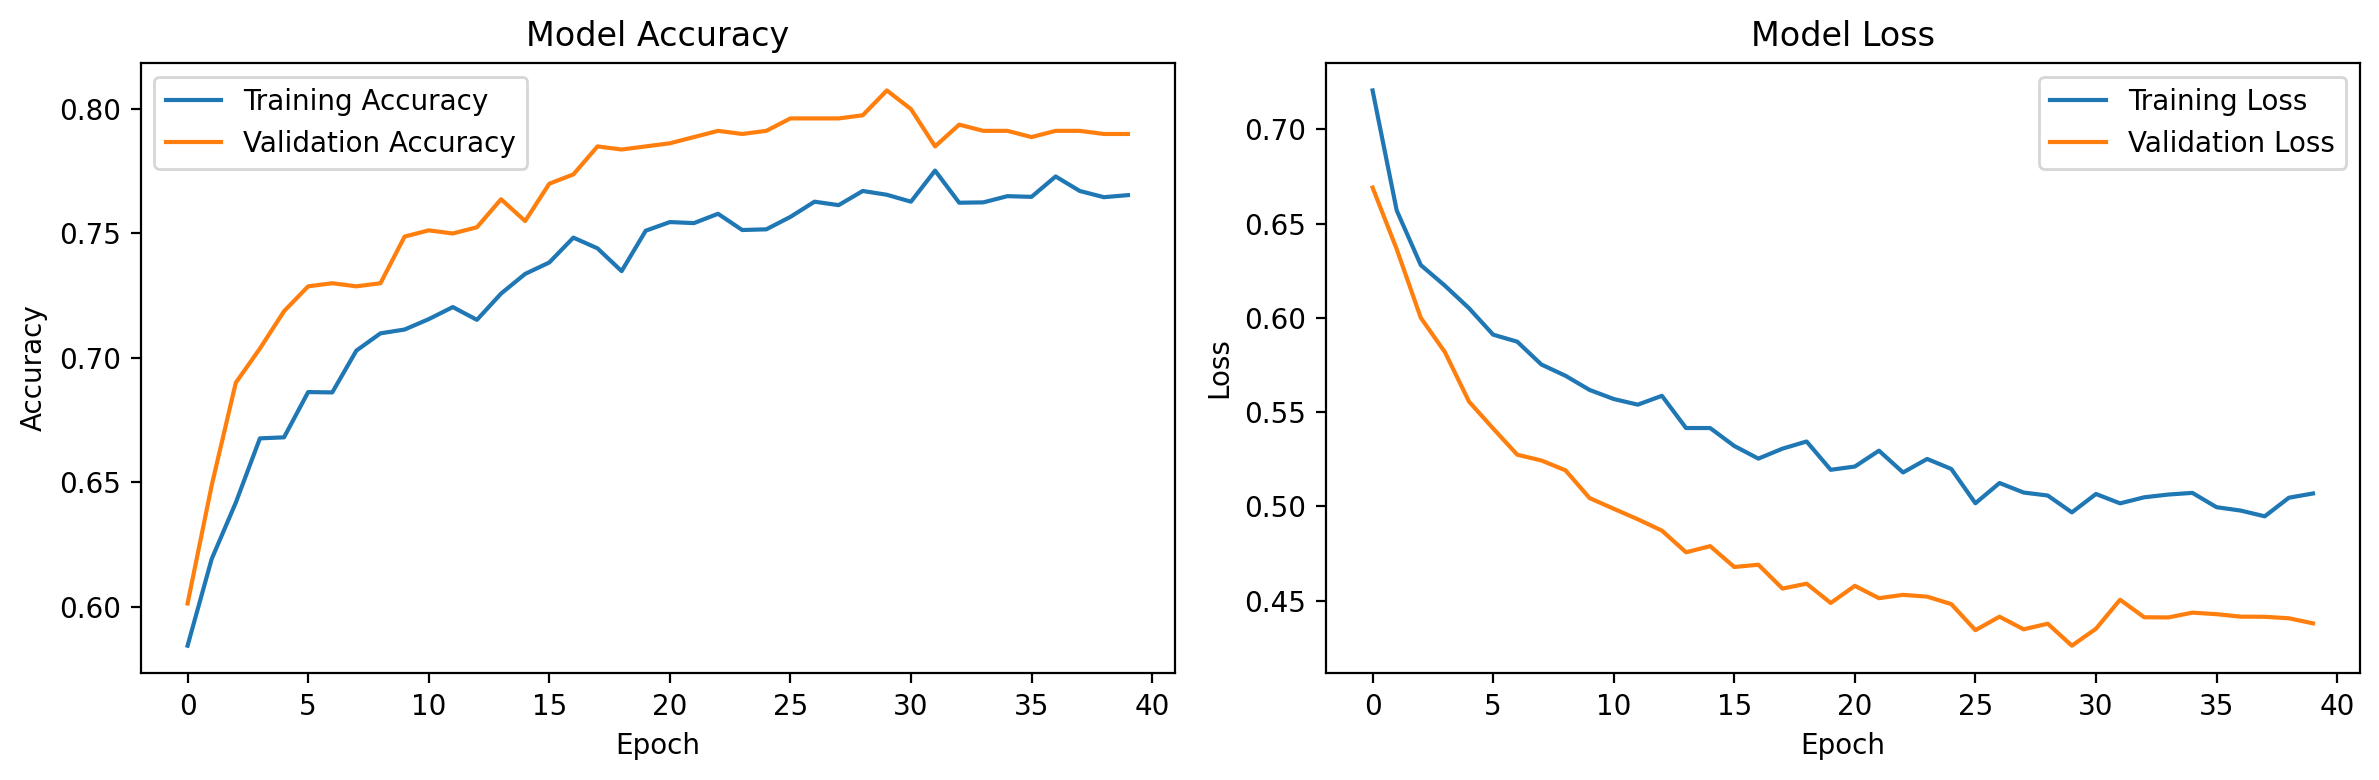

In [28]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [29]:
from sklearn.metrics import classification_report, confusion_matrix

In [30]:
y_pred = model.predict(X_test)

63/63 [==============================] - 0s 1ms/step


In [31]:
y_pred = (y_pred>0.5).astype(int)

## 🧾 24. Classification Report

We display Precision, Recall, and F1-score for both churn and non-churn cases.  
These metrics are **more meaningful than accuracy** when dealing with imbalanced data.

---

In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.78      0.85      1593
           1       0.47      0.76      0.58       407

    accuracy                           0.78      2000
   macro avg       0.70      0.77      0.72      2000
weighted avg       0.83      0.78      0.80      2000



## 💾 25. Saving the Model and Scaler

We save:
- The trained neural network
- The feature scaling transformer

This allows the model to be used in applications, dashboards, or APIs later.

---

In [ ]:
import pickle 
import os

In [ ]:
os.makedirs('model', exist_ok = True)

In [ ]:
model.save('model/churn_model.h5')

In [ ]:
pickle.dump(scaler, open('model/scaler.pkl','wb'))

## 🔍 26. Loading and Testing the Saved Model

We load the saved components and run a prediction on a test example to verify the deployment workflow.


In [ ]:
model1 = keras.models.load_model('model/churn_model.h5')
scaler1 = pickle.load(open('model/scaler.pkl','rb'))

In [ ]:
test = [[400.0, 62.0, 2.0, 0.0, 1.0, 1.0, 1.0, 101348.88, 0.0, 0.0, 1]]
test = scaler1.transform(test)
(model1.predict(test)> 0.5).astype(int)

1/1 [==============================] - 0s 94ms/step


c:\Users\arash\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([[1]])